In [5]:
## Test the trained tflite model on new data. 

In [6]:
#!pip install cryptography --upgrade

In [7]:
#!pip install tflite-model-maker
#!pip install pycocotools

Import the required packages.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [9]:
!python --version
tf.__version__


Python 3.8.8


'2.5.0'

In [10]:
#!conda env list   # base env was active on Peter's PC

In [11]:
spec = model_spec.get('efficientdet_lite1')
spec.config.num_classes=2              # carotene (orange), white
spec.config.tflite_max_detections=100  # <<< default is 100
spec.config.label_map={1: "car", 2: "white"} 
#print(spec.config)


In [12]:
%pwd

In [19]:
import cv2

from PIL import Image

model_path = 'model_50.tflite'      # <<<==== old trained model, check for model.tflite

# Load the labels into a list
classes = ['???'] * spec.config.num_classes
label_map = spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
    classes[label_id-1] = label_name


# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Return the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


# A high confidence threshold will prevent most overlaps, but not all.
# boxes_overlap was designedtp prevnt the same colony from being detected more 
# once.
def boxes_overlap(ymin1, xmin1, ymax1, xmax1, ymin2, xmin2, ymax2, xmax2):
    
   # if (xmin1 == xmin2 or ymin1 == ymin2 or xmax1 == xmax2 or ymax1 == ymax2):
   #    # the line cannot have positive overlap
   #     return False
         
    # If one rectangle is on left side of other
    if(xmin1 >= xmax2 or xmax1 <= xmin2):
        return False
 
    # If one rectangle is above other
    if(ymax1 <= ymin2 or ymax2 <= ymin1):
        return False
 
    return True


# Puts list of results in ascending order by score
# Returns true if two rectangles overlap
def filter_results(results):

    results_filtered = []  #{'bounding_box':[], 'score':0, 'class_id': 0 }
    
    mylist =[]
    for ii in range(len(results)):
        mylist.append(results[ii]['score'])

    mylist=np.array(mylist)
    idx = np.argsort(mylist*-1)  # want desceding order, == reverse

    results_sorted = []
    for ii in idx:
        results_sorted.append(results[ii])
        
    results = results_sorted   
    
    #verify order    
#     for ii in range(len(results)):
#         print(results[ii]['score'])
    
    for ii in range( len(results) ):
        ymin1, xmin1, ymax1, xmax1 = results[ii]['bounding_box']
        overlap=False
        
        for jj in range(len(results) ):
            if ii==jj:
                continue
        
            ymin2, xmin2, ymax2, xmax2 = results[jj]['bounding_box']
            
            if boxes_overlap(ymin1, xmin1, ymax1, xmax1, ymin2, xmin2, ymax2, xmax2)\
                and results[ii]['score'] <= results[jj]['score']:
                    overlap=True
                    break

            
        if overlap == False:    
            results_filtered.append(results[ii])  # for cases of overlap, this box had highest score
                  
    return results_filtered



def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
        
  print('first box: ', boxes[0])
  print('result count: ', len(results))
    
  return results



def run_odt_and_draw_results(image_path, interpreter, filter_boolean, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(image_path,
      (input_height, input_width)
    )
    
  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  if filter_boolean:
    print("filtering=True")
    results = filter_results(results)
    
  print("length of filtered results: ", len(results))

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)

  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])
    
#     if abs(xmax - xmin) < 1 or abs(ymax-ymin) < 1: # too small to be a valid colony
#         continue

    ## for debugging
    #print(obj['score'] * 100, "==>", xmin,xmax,ymin,ymax,"\n")

    # Find the class index of the current object
    class_id = int(obj['class_id'])
    #print(class_id) # 0, 1, ...

    # Draw the bounding box and label on the image
    color = 1 # [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 1)
    # Make adjustments to make the label visible for all objects
    y = ymin - 7 if ymin - 7 > 7 else ymin + 7
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)

    #label = "{}: {:.0f}%".format('col', obj['score'] * 100)
    
    cv2.putText(original_image_np, label, (xmin, y), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.85, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return (preprocessed_image, original_uint8)

In [14]:
!ls data-set-maker

01_rotate_images.py  04_norm_coords_and_format.py  images-26-orange-white
02_label_to_csv.py   images-25-26-orange-white	   saved_model
03_rotate_boxes.py   images-25-orange-white


In [20]:
!ls data-set-maker/images-25-26-orange-white/test 

test-1.jpg  test-2.jpg	test-3.jpg


In [42]:
#@title Run object detection and show the detection results

# If trained using only a small number of epochs (~5 or 10), classification will be bad, 
# probably need between 50 and 100 epochs (100 takes about 1 hour?).

# If more training, can set the detection (confidence) threshold higher than 0.15.
# Basically, there is a trade-off between true positives and false positives, etc.
#
DETECTION_THRESHOLD = 0.20 # <<<<<<<<<<<================== confidence!
filter_boolean=True        # <<<<<<<<<<<================== excludes ovelapping boxes

test_folder="data-set-maker/images-25-26-orange-white/test/"

test_files= os.listdir(test_folder)

test_path= test_folder + test_files[0]  # <<<=================== choose test file


print(test_path, "\n")

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
(preprocessed_image, detection_result_image) = run_odt_and_draw_results(
    test_path,
    interpreter,
    filter_boolean,
    threshold=DETECTION_THRESHOLD
)


data-set-maker/images-25-26-orange-white/test/test-2.jpg 

first box:  [0.1314027  0.63140273 0.1810973  0.68109727]
result count:  19
filtering=True
length of filtered results:  18


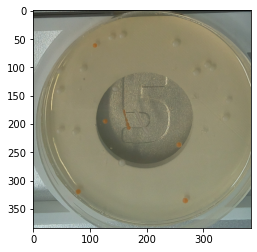

In [43]:
img=preprocessed_image[0,:,:,:]/255
temp=plt.imshow(img)
#print(type(img))

#tf.keras.preprocessing.image.save_img('temp.png',img)

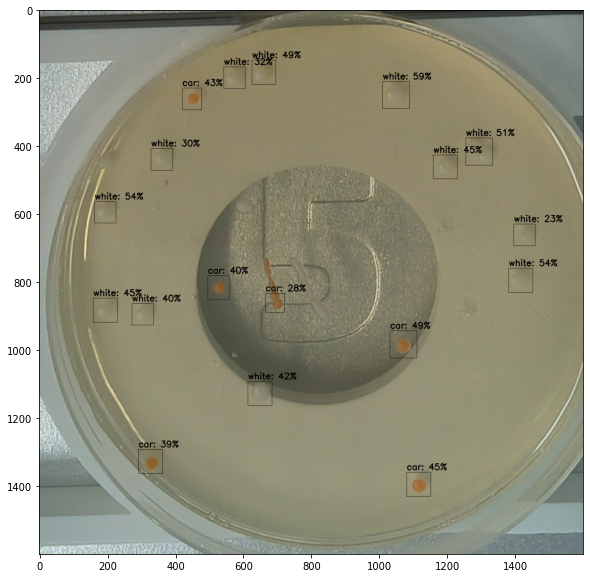

In [44]:
# Show the detection result

result_img=Image.fromarray(detection_result_image)
plt.figure(figsize=(10,10))
temp=plt.imshow(result_img)